In [1]:
import numpy as np

In [754]:
def conv2D(X, W, stride, pad, dilation=0):
    """
    A faster (but more memory intensive) implementation of the 2D "convolution"
    (technically, cross-correlation) of input `X` with a collection of kernels in
    `W`.
    Notes
    -----
    Relies on the :func:`im2col` function to perform the convolution as a single
    matrix multiplication.
    For a helpful diagram, see Pete Warden's 2015 blogpost [1].
    References
    ----------
    .. [1] Warden (2015). "Why GEMM is at the heart of deep learning,"
       https://petewarden.com/2015/04/20/why-gemm-is-at-the-heart-of-deep-learning/
    Parameters
    ----------
    X : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, in_rows, in_cols, in_ch)`
        Input volume (unpadded).
    W: :py:class:`ndarray <numpy.ndarray>` of shape `(kernel_rows, kernel_cols, in_ch, out_ch)`
        A volume of convolution weights/kernels for a given layer.
    stride : int
        The stride of each convolution kernel.
    pad : tuple, int, or 'same'
        The padding amount. If 'same', add padding to ensure that the output of
        a 2D convolution with a kernel of `kernel_shape` and stride `stride`
        produces an output volume of the same dimensions as the input.  If
        2-tuple, specifies the number of padding rows and colums to add *on both
        sides* of the rows/columns in `X`. If 4-tuple, specifies the number of
        rows/columns to add to the top, bottom, left, and right of the input
        volume.
    dilation : int
        Number of pixels inserted between kernel elements. Default is 0.
    Returns
    -------
    Z : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, out_rows, out_cols, out_ch)`
        The covolution of `X` with `W`.
    """
    s, d = stride, dilation
    _, p = pad2D(X, pad, W.shape[:2], s, dilation=dilation)

    pr1, pr2, pc1, pc2 = p
    fr, fc, in_ch, out_ch = W.shape
    n_ex, in_rows, in_cols, in_ch = X.shape

    # update effective filter shape based on dilation factor
    _fr, _fc = fr * (d + 1) - d, fc * (d + 1) - d

    # compute the dimensions of the convolution output
    out_rows = int((in_rows + pr1 + pr2 - _fr) / s + 1)
    out_cols = int((in_cols + pc1 + pc2 - _fc) / s + 1)

    # convert X and W into the appropriate 2D matrices and take their product
    X_col, _ = im2col(X, W.shape, p, s, d)
    W_col = W.transpose(3, 2, 0, 1).reshape(out_ch, -1)

    Z = (W_col @ X_col).reshape(out_ch, out_rows, out_cols, n_ex).transpose(3, 1, 2, 0)

    return Z

In [755]:
def im2col(X, W_shape, pad, stride, dilation=0):
    """
    Pads and rearrange overlapping windows of the input volume into column
    vectors, returning the concatenated padded vectors in a matrix `X_col`.
    Notes
    -----
    A NumPy reimagining of MATLAB's ``im2col`` 'sliding' function.
    Code extended from Andrej Karpathy's ``im2col.py``.
    Parameters
    ----------
    X : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, in_rows, in_cols, in_ch)`
        Input volume (not padded).
    W_shape: 4-tuple containing `(kernel_rows, kernel_cols, in_ch, out_ch)`
        The dimensions of the weights/kernels in the present convolutional
        layer.
    pad : tuple, int, or 'same'
        The padding amount. If 'same', add padding to ensure that the output of
        a 2D convolution with a kernel of `kernel_shape` and stride `stride`
        produces an output volume of the same dimensions as the input.  If
        2-tuple, specifies the number of padding rows and colums to add *on both
        sides* of the rows/columns in X. If 4-tuple, specifies the number of
        rows/columns to add to the top, bottom, left, and right of the input
        volume.
    stride : int
        The stride of each convolution kernel
    dilation : int
        Number of pixels inserted between kernel elements. Default is 0.
    Returns
    -------
    X_col : :py:class:`ndarray <numpy.ndarray>` of shape (Q, Z)
        The reshaped input volume where where:
        .. math::
            Q  &=  \\text{kernel_rows} \\times \\text{kernel_cols} \\times \\text{n_in} \\\\
            Z  &=  \\text{n_ex} \\times \\text{out_rows} \\times \\text{out_cols}
    """
    fr, fc, n_in, n_out = W_shape
    s, p, d = stride, pad, dilation
    n_ex, in_rows, in_cols, n_in = X.shape

    # zero-pad the input
    X_pad, p = pad2D(X, p, W_shape[:2], stride=s, dilation=d)
    pr1, pr2, pc1, pc2 = p

    # shuffle to have channels as the first dim
    X_pad = X_pad.transpose(0, 3, 1, 2)

    # get the indices for im2col
    k, i, j = _im2col_indices((n_ex, n_in, in_rows, in_cols), fr, fc, p, s, d)

    X_col = X_pad[:, k, i, j]
    X_col = X_col.transpose(1, 2, 0).reshape(fr * fc * n_in, -1)
    return X_col, p

In [756]:
def pad2D(X, pad, kernel_shape=None, stride=None, dilation=0):
    """
    Zero-pad a 4D input volume `X` along the second and third dimensions.
    Parameters
    ----------
    X : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, in_rows, in_cols, in_ch)`
        Input volume. Padding is applied to `in_rows` and `in_cols`.
    pad : tuple, int, or 'same'
        The padding amount. If 'same', add padding to ensure that the output of
        a 2D convolution with a kernel of `kernel_shape` and stride `stride`
        has the same dimensions as the input.  If 2-tuple, specifies the number
        of padding rows and colums to add *on both sides* of the rows/columns
        in `X`. If 4-tuple, specifies the number of rows/columns to add to the
        top, bottom, left, and right of the input volume.
    kernel_shape : 2-tuple
        The dimension of the 2D convolution kernel. Only relevant if p='same'.
        Default is None.
    stride : int
        The stride for the convolution kernel. Only relevant if p='same'.
        Default is None.
    dilation : int
        The dilation of the convolution kernel. Only relevant if p='same'.
        Default is 0.
    Returns
    -------
    X_pad : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, padded_in_rows, padded_in_cols, in_channels)`
        The padded output volume.
    p : 4-tuple
        The number of 0-padded rows added to the (top, bottom, left, right) of
        `X`.
    """
    p = pad
    if isinstance(p, int):
        p = (p, p, p, p)

    if isinstance(p, tuple):
        if len(p) == 2:
            p = (p[0], p[0], p[1], p[1])

        X_pad = np.pad(
            X,
            pad_width=((0, 0), (p[0], p[1]), (p[2], p[3]), (0, 0)),
            mode="constant",
            constant_values=0,
        )

    # compute the correct padding dims for a 'same' convolution
    if p == "same" and kernel_shape and stride is not None:
        p = calc_pad_dims_2D(
            X.shape, X.shape[1:3], kernel_shape, stride, dilation=dilation
        )
        X_pad, p = pad2D(X, p)
    return X_pad, p


In [757]:
def _im2col_indices(X_shape, fr, fc, p, s, d=0):
    """
    Helper function that computes indices into X in prep for columnization in
    :func:`im2col`.
    Code extended from Andrej Karpathy's `im2col.py`
    """
    pr1, pr2, pc1, pc2 = p
    n_ex, n_in, in_rows, in_cols = X_shape

    # adjust effective filter size to account for dilation
    _fr, _fc = fr * (d + 1) - d, fc * (d + 1) - d

    out_rows = (in_rows + pr1 + pr2 - _fr) // s + 1
    out_cols = (in_cols + pc1 + pc2 - _fc) // s + 1

    if any([out_rows <= 0, out_cols <= 0]):
        raise ValueError(
            "Dimension mismatch during convolution: "
            "out_rows = {}, out_cols = {}".format(out_rows, out_cols)
        )

    # i1/j1 : row/col templates
    # i0/j0 : n. copies (len) and offsets (values) for row/col templates
    i0 = np.repeat(np.arange(fr), fc)
    i0 = np.tile(i0, n_in) * (d + 1)
    i1 = s * np.repeat(np.arange(out_rows), out_cols)
    j0 = np.tile(np.arange(fc), fr * n_in) * (d + 1)
    j1 = s * np.tile(np.arange(out_cols), out_rows)

    # i.shape = (fr * fc * n_in, out_height * out_width)
    # j.shape = (fr * fc * n_in, out_height * out_width)
    # k.shape = (fr * fc * n_in, 1)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
    k = np.repeat(np.arange(n_in), fr * fc).reshape(-1, 1)
    return k, i, j

In [758]:
def dilate(X, d):
    """
    Dilate the 4D volume `X` by `d`.
    Notes
    -----
    For a visual depiction of a dilated convolution, see [1].
    References
    ----------
    .. [1] Dumoulin & Visin (2016). "A guide to convolution arithmetic for deep
       learning." https://arxiv.org/pdf/1603.07285v1.pdf
    Parameters
    ----------
    X : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, in_rows, in_cols, in_ch)`
        Input volume.
    d : int
        The number of 0-rows to insert between each adjacent row + column in `X`.
    Returns
    -------
    Xd : :py:class:`ndarray <numpy.ndarray>` of shape `(n_ex, out_rows, out_cols, out_ch)`
        The dilated array where
        .. math::
            \\text{out_rows}  &=  \\text{in_rows} + d(\\text{in_rows} - 1) \\\\
            \\text{out_cols}  &=  \\text{in_cols} + d (\\text{in_cols} - 1)
    """
    n_ex, in_rows, in_cols, n_in = X.shape
    r_ix = np.repeat(np.arange(1, in_rows), d)
    c_ix = np.repeat(np.arange(1, in_cols), d)
    Xd = np.insert(X, r_ix, 0, axis=1)
    Xd = np.insert(Xd, c_ix, 0, axis=2)
    return Xd


In [759]:
def calc_pad_dims_2D(X_shape, out_dim, kernel_shape, stride, dilation=0):
    """
    Compute the padding necessary to ensure that convolving `X` with a 2D kernel
    of shape `kernel_shape` and stride `stride` produces outputs with dimension
    `out_dim`.
    Parameters
    ----------
    X_shape : tuple of `(n_ex, in_rows, in_cols, in_ch)`
        Dimensions of the input volume. Padding is applied to `in_rows` and
        `in_cols`.
    out_dim : tuple of `(out_rows, out_cols)`
        The desired dimension of an output example after applying the
        convolution.
    kernel_shape : 2-tuple
        The dimension of the 2D convolution kernel.
    stride : int
        The stride for the convolution kernel.
    dilation : int
        Number of pixels inserted between kernel elements. Default is 0.
    Returns
    -------
    padding_dims : 4-tuple
        Padding dims for `X`. Organized as (left, right, up, down)
    """
    if not isinstance(X_shape, tuple):
        raise ValueError("`X_shape` must be of type tuple")

    if not isinstance(out_dim, tuple):
        raise ValueError("`out_dim` must be of type tuple")

    if not isinstance(kernel_shape, tuple):
        raise ValueError("`kernel_shape` must be of type tuple")

    if not isinstance(stride, int):
        raise ValueError("`stride` must be of type int")

    d = dilation
    fr, fc = kernel_shape
    out_rows, out_cols = out_dim
    n_ex, in_rows, in_cols, in_ch = X_shape

    # update effective filter shape based on dilation factor
    _fr, _fc = fr * (d + 1) - d, fc * (d + 1) - d

    pr = int((stride * (out_rows - 1) + _fr - in_rows) / 2)
    pc = int((stride * (out_cols - 1) + _fc - in_cols) / 2)

    out_rows1 = int(1 + (in_rows + 2 * pr - _fr) / stride)
    out_cols1 = int(1 + (in_cols + 2 * pc - _fc) / stride)

    # add asymmetric padding pixels to right / bottom
    pr1, pr2 = pr, pr
    if out_rows1 == out_rows - 1:
        pr1, pr2 = pr, pr + 1
    elif out_rows1 != out_rows:
        raise AssertionError

    pc1, pc2 = pc, pc
    if out_cols1 == out_cols - 1:
        pc1, pc2 = pc, pc + 1
    elif out_cols1 != out_cols:
        raise AssertionError

    if any(np.array([pr1, pr2, pc1, pc2]) < 0):
        raise ValueError(
            "Padding cannot be less than 0. Got: {}".format((pr1, pr2, pc1, pc2))
        )
    return (pr1, pr2, pc1, pc2)


In [760]:
class Conv2D():
    def __init__(
        self,
        out_ch,
        kernel_shape,
        pad=0,
        stride=1,
        dilation=0,
        act_fn=None,
        optimizer=None,
        init="glorot_uniform",
    ):

        
        super().__init__()

        self.pad = pad
        self.init = init
        self.in_ch = 3
        self.out_ch = out_ch
        self.stride = stride
        self.dilation = dilation
        self.kernel_shape = kernel_shape
        self.parameters = {"W": None, "b": None}
        self.is_initialized = False

    def _init_params(self):

        fr, fc = self.kernel_shape
        W = np.random.randn(fr, fc, self.in_ch, self.out_ch)
        b = np.zeros((1, 1, 1, self.out_ch))

        self.parameters = {"W": W, "b": b}
        self.gradients = {"W": np.zeros_like(W), "b": np.zeros_like(b)}
        self.derived_variables = {"Z": [], "out_rows": [], "out_cols": []}
        self.is_initialized = True


    def forward(self, X, retain_derived=True):
        
        if not self.is_initialized:
            self.in_ch = X.shape[3]
            self._init_params()

        W = self.parameters["W"]
        b = self.parameters["b"]

        n_ex, in_rows, in_cols, in_ch = X.shape
        s, p, d = self.stride, self.pad, self.dilation

        # pad the input and perform the forward convolution
        Z = conv2D(X, W, s, p, d) + b
        



        return Z


In [761]:
from sklearn import datasets


In [762]:
#data = datasets.load_digits()
#X = data.data
#y = data.target


In [763]:
imgs = np.load('../../downloads/catdog.npy',allow_pickle=True)
labels = np.load('../../downloads/catdoglabels.npy',allow_pickle=True)

In [764]:
X = imgs
y = labels

In [765]:
from metal.utils import train_test_split, to_categorical, normalize


In [775]:
X_train_, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, seed = 1)


In [776]:
c1 = Conv2D(1,((5,5)),'same',stride=1)

In [777]:

c1._init_params()
c1.parameters["b"].shape


(1, 1, 1, 1)

In [778]:
X_train_.shape

(1200, 224, 224, 3)

In [794]:
X_train = X_train_[91].reshape((1,224,224,3))
X_train.shape

(1, 224, 224, 3)

In [795]:
z=c1.forward(X_train)

In [796]:
z.shape


(1, 224, 224, 1)

In [797]:
import matplotlib.pyplot as plt


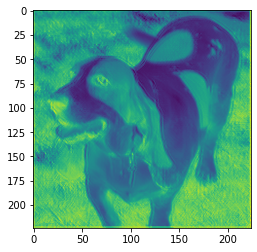

In [798]:
plt.imshow(z[0].reshape( 224, 224),interpolation='lanczos')

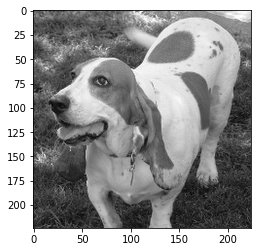

In [799]:
plt.imshow(X_train.reshape((224,224,3)),interpolation='lanczos')

In [12]:
np.sqrt(2*8*8)

11.313708498984761

In [1]:
import autograd.numpy as np
import numpy as _np
from autograd import grad
from metal.utils.utils import conv2D

In [2]:
x = np.array(np.linspace(-7, 7, 2))
c = np.linspace(-3, 3, 2)
j = np.linspace(-1, 1, 2)
x,c,j,np.tile

(array([-7.,  7.]),
 array([-3.,  3.]),
 array([-1.,  1.]),
 <function autograd.tracer.primitive.<locals>.f_wrapped(*args, **kwargs)>)

In [9]:
#from metal.backend.numpy_backend import _pool2D_Keras_forward

In [10]:
#def s(x):
    #return np.sum(_pool2D_Keras_forward(x,(2,2),(2,2),"same","max","channel_last"))

In [11]:
# We could use np.tanh, but let's write our own as an example.
def tanh(z):
    return np.sum( z+c+j )


In [12]:
tanh(x)

0.0

In [13]:
grad(tanh)(x)

<function primitive.<locals>.f_wrapped at 0x7fe5f3ac9f80> 0


KeyError: 0

In [8]:
d = {}
d['m'] = 1

In [9]:
d

{'m': 1}

In [2]:
x = np.array(_np.random.randn(2,3,3,3))
w = np.array(_np.random.randn(2,3,3,3).T)

def c (z,h):
    return np.sum(conv2D(z,h,2,"same",0))

In [1]:
g = grad(c,1)
g(x)


NameError: name 'grad' is not defined

In [7]:
x.transpose((0,3,2,1))

array([[[[-0.77795768,  0.44993242, -2.06976815],
         [-0.5602488 , -0.35768175, -1.6008221 ],
         [ 1.88851135, -0.72104741,  0.7400739 ]],

        [[ 0.00784611, -0.5000769 ,  0.23201761],
         [ 1.13115694,  0.47975205, -1.0481919 ],
         [-0.74112884, -0.1371146 , -1.89618261]],

        [[ 3.33058601, -1.10198266, -0.27954601],
         [-0.39024149,  1.33765451, -1.19480715],
         [-1.09625521, -0.54854426,  1.34047838]]],


       [[[ 0.17684909, -0.83290567,  0.18413738],
         [-1.24476431,  2.10694354,  1.57600909],
         [ 1.89067573, -0.39657204,  1.59485982]],

        [[-0.76336331, -1.82183408,  0.5631121 ],
         [-0.6194804 , -1.481644  , -1.63261503],
         [ 0.15047593,  0.13120998,  0.86404418]],

        [[-0.76810516, -0.64390946, -0.53580982],
         [-1.27773462,  0.60361844,  2.30697489],
         [ 0.78413283,  0.13618301,  0.3141704 ]]]])